In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/master_features_nca.csv")
df

,filename,cell_id,temp,charge_rate,discharge_rate,cycle,SOH,IC_bin_1,IC_bin_2,IC_bin_3,...,IC_bin_11,IC_bin_12,IC_bin_13,IC_bin_14,IC_bin_15,IC_bin_16,IC_bin_17,IC_bin_18,IC_bin_19,IC_bin_20
0,CY25-025_1-#1.csv,1,25,0.25,1.0,1,99.96,3.206253,3.435524,3.772510,...,4.255246,4.207070,4.229390,4.248806,4.264151,4.198406,4.058616,3.920543,3.792856,3.647914
1,CY25-025_1-#1.csv,1,25,0.25,1.0,2,99.98,3.185611,3.409977,3.737496,...,4.249921,4.223132,4.181276,4.225006,4.231327,4.158785,4.055173,3.905594,3.737473,3.648392
2,CY25-025_1-#1.csv,1,25,0.25,1.0,3,100.00,3.166235,3.397673,3.713245,...,4.235653,4.189766,4.140167,4.167926,4.180849,4.145106,4.015124,3.896722,3.756668,3.646670
3,CY25-025_1-#1.csv,1,25,0.25,1.0,4,99.97,3.139468,3.376350,3.683448,...,4.254307,4.162355,4.134256,4.143371,4.135573,4.118733,4.023064,3.867330,3.752034,3.631178
4,CY25-025_1-#1.csv,1,25,0.25,1.0,5,99.93,3.132129,3.346752,3.653736,...,4.216513,4.164974,4.094929,4.101335,4.135343,4.100581,4.008745,3.881142,3.761407,3.626212
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22639,CY45-05_1-#9.csv,9,45,0.50,1.0,411,84.65,2.514883,2.565545,2.627766,...,3.248165,3.376864,3.545380,3.705835,3.774339,3.705556,3.564230,3.413748,3.287599,3.193869
22640,CY45-05_1-#9.csv,9,45,0.50,1.0,412,84.61,2.510205,2.560754,2.625429,...,3.250500,3.392370,3.559592,3.706725,3.763518,3.694866,3.559024,3.417873,3.299083,3.207045
22641,CY45-05_1-#9.csv,9,45,0.50,1.0,413,84.60,2.513525,2.562124,2.623266,...,3.245492,3.372555,3.540142,3.694258,3.752898,3.692722,3.562536,3.425323,3.303745,3.206924
22642,CY45-05_1-#9.csv,9,45,0.50,1.0,414,84.58,2.508238,2.557557,2.619624,...,3.241048,3.372799,3.540815,3.700767,3.761809,3.701606,3.569719,3.425509,3.299934,3.202914


In [4]:
# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


In [5]:
from tqdm import tqdm

batch_size = 32

y_train_tf = y_train.reshape(-1,1).astype(np.float32)
y_test_tf = y_test.reshape(-1,1).astype(np.float32)

train_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_train.astype(np.float32),X_context_train.astype(np.float32),
     y_train_tf)).shuffle(buffer_size=len(X_ic_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (X_ic_test.astype(np.float32), X_context_test.astype(np.float32),
    y_test_tf)).batch(batch_size)

In [6]:
@tf.function
def candw_attack(model, x_ic_batch, x_ctx_batch, y_batch,
                 attack_weight=1.0, lr=0.01, steps=100,
                 clip_min=-3.0, clip_max=3.0):

    x_ic_batch = tf.cast(x_ic_batch, tf.float32)
    x_ctx_batch = tf.cast(x_ctx_batch, tf.float32)
    y_batch = tf.cast(y_batch, tf.float32)
    y_batch = tf.expand_dims(y_batch, axis=-1)

    # make all constants float32
    clip_min = tf.cast(clip_min, tf.float32)
    clip_max = tf.cast(clip_max, tf.float32)
    attack_weight = tf.cast(attack_weight, tf.float32)
    lr = tf.cast(lr, tf.float32)

    # steps must be int32 for tf.while_loop
    steps = tf.cast(steps, tf.int32)

    delta = tf.zeros_like(x_ic_batch, dtype=tf.float32)

    def body(i, delta):
        with tf.GradientTape() as tape:
            tape.watch(delta)

            x_adv = x_ic_batch + delta
            x_adv = tf.clip_by_value(x_adv, clip_min, clip_max)

            y_pred = model([x_adv, x_ctx_batch], training=False)

            mse = tf.reduce_mean(tf.keras.losses.MSE(y_batch, y_pred))
            l2 = tf.reduce_mean(tf.reduce_sum(tf.square(delta), axis=[1, 2]))

            loss = l2 - attack_weight * mse

        grads = tape.gradient(loss, delta)
        delta = delta - lr * grads
        return i + 1, delta

    _, delta = tf.while_loop(
        cond=lambda i, _: i < steps,
        body=body,
        loop_vars=(0, delta)
    )

    x_adv = tf.clip_by_value(x_ic_batch + delta, clip_min, clip_max)
    return x_adv


In [7]:
cnn_gru = keras.models.load_model(r"/content/drive/MyDrive/Colab Notebooks/best_cnn_gru.keras")

In [8]:
learning_rate = 1e-5

best_val_mse = float('inf')
patience = 5
patience_counter = 0
epochs = 20

optimizer = tf.optimizers.Adam(learning_rate = learning_rate)
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_loss_fn = MeanSquaredError()

train_mae_history = []
train_mse_history = []
val_mse_history = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    total_mse = 0.0
    total_mae = 0.0
    num_batches = 0

    train_pbar = tqdm(train_dataset, desc = "Training", leave=True)

    for(x_ic_batch , x_ctx_batch, y_batch) in train_pbar:

        x_adv = candw_attack(cnn_gru, x_ic_batch, x_ctx_batch, y_batch)


        with tf.GradientTape() as tape:
            y_pred_adv = cnn_gru([x_adv, x_ctx_batch], training = True)
            mse_loss = mse_loss_fn(y_batch,y_pred_adv)

        grads = tape.gradient(mse_loss, cnn_gru.trainable_variables)
        optimizer.apply_gradients(zip(grads, cnn_gru.trainable_variables))

        mae_metric.reset_state()
        mae_metric.update_state(y_batch, y_pred_adv)
        batch_mae = mae_metric.result().numpy()

        total_mse += mse_loss.numpy()
        total_mae += batch_mae
        num_batches+=1

        train_pbar.set_postfix(mse = f"{mse_loss.numpy():.4f}", mae=f"{batch_mae:.4f}")


    avg_mse = total_mse / num_batches
    avg_mae = total_mae / num_batches

    train_mse_history.append(avg_mse)
    train_mae_history.append(avg_mae)


    print(f"Train MSE: {avg_mse:.4f} | Train MAE : {avg_mae:.4f}")

    val_mse = 0.0
    num_val_batches = 0

    val_pbar = tqdm(test_dataset, desc = "Validating", leave=True)

    for(x_ic_batch,x_ctx_batch, y_batch) in val_pbar:
        pred_val = cnn_gru([x_ic_batch, x_ctx_batch], training=False)
        batch_mse= mse_loss_fn(y_batch, pred_val).numpy()

        val_mse += batch_mse
        num_val_batches += 1

        val_pbar.set_postfix(mse=f"{batch_mse:.4f}")


    val_mse /=num_val_batches
    val_mse_history.append(val_mse)

    print(f"Validation MSE: {val_mse:.4f}")

    if val_mse < best_val_mse:
        print("Validation improved, saving model ...")
        best_val_mse = val_mse
        patience_counter = 0
        cnn_gru.save("c&w_trained_cnn_gru.keras")

    else:
        patience_counter +=1
        print(f"No improvement. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered")
            break


Epoch 1/20


Training: 100%|██████████| 566/566 [02:39<00:00,  3.55it/s, mae=0.3355, mse=0.2005]


Train MSE: 0.3288 | Train MAE : 0.4743


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.19it/s, mse=0.1566]


Validation MSE: 0.1247
Validation improved, saving model ...

Epoch 2/20


Training: 100%|██████████| 566/566 [02:34<00:00,  3.66it/s, mae=0.1602, mse=0.0385]


Train MSE: 0.1012 | Train MAE : 0.2478


Validating: 100%|██████████| 142/142 [00:02<00:00, 52.39it/s, mse=0.0627]


Validation MSE: 0.0487
Validation improved, saving model ...

Epoch 3/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.64it/s, mae=0.1334, mse=0.0359]


Train MSE: 0.0542 | Train MAE : 0.1741


Validating: 100%|██████████| 142/142 [00:02<00:00, 52.04it/s, mse=0.0280]


Validation MSE: 0.0249
Validation improved, saving model ...

Epoch 4/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.63it/s, mae=0.1035, mse=0.0158]


Train MSE: 0.0376 | Train MAE : 0.1431


Validating: 100%|██████████| 142/142 [00:05<00:00, 27.82it/s, mse=0.0157]


Validation MSE: 0.0152
Validation improved, saving model ...

Epoch 5/20


Training: 100%|██████████| 566/566 [03:21<00:00,  2.80it/s, mae=0.1164, mse=0.0205]


Train MSE: 0.0299 | Train MAE : 0.1264


Validating: 100%|██████████| 142/142 [00:03<00:00, 42.34it/s, mse=0.0112]


Validation MSE: 0.0106
Validation improved, saving model ...

Epoch 6/20


Training: 100%|██████████| 566/566 [02:36<00:00,  3.61it/s, mae=0.1144, mse=0.0205]


Train MSE: 0.0256 | Train MAE : 0.1161


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.07it/s, mse=0.0068]


Validation MSE: 0.0080
Validation improved, saving model ...

Epoch 7/20


Training: 100%|██████████| 566/566 [02:36<00:00,  3.63it/s, mae=0.1258, mse=0.0254]


Train MSE: 0.0239 | Train MAE : 0.1101


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.83it/s, mse=0.0055]


Validation MSE: 0.0068
Validation improved, saving model ...

Epoch 8/20


Training: 100%|██████████| 566/566 [02:36<00:00,  3.61it/s, mae=0.0944, mse=0.0207]


Train MSE: 0.0222 | Train MAE : 0.1059


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.70it/s, mse=0.0047]


Validation MSE: 0.0061
Validation improved, saving model ...

Epoch 9/20


Training: 100%|██████████| 566/566 [02:36<00:00,  3.62it/s, mae=0.0858, mse=0.0214]


Train MSE: 0.0212 | Train MAE : 0.1029


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.73it/s, mse=0.0054]


Validation MSE: 0.0059
Validation improved, saving model ...

Epoch 10/20


Training: 100%|██████████| 566/566 [03:21<00:00,  2.80it/s, mae=0.0944, mse=0.0189]


Train MSE: 0.0209 | Train MAE : 0.1022


Validating: 100%|██████████| 142/142 [00:02<00:00, 48.00it/s, mse=0.0048]


Validation MSE: 0.0055
Validation improved, saving model ...

Epoch 11/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.64it/s, mae=0.1472, mse=0.0623]


Train MSE: 0.0202 | Train MAE : 0.1003


Validating: 100%|██████████| 142/142 [00:03<00:00, 40.03it/s, mse=0.0032]


Validation MSE: 0.0051
Validation improved, saving model ...

Epoch 12/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.64it/s, mae=0.1089, mse=0.0249]


Train MSE: 0.0198 | Train MAE : 0.0989


Validating: 100%|██████████| 142/142 [00:02<00:00, 47.95it/s, mse=0.0035]


Validation MSE: 0.0051
Validation improved, saving model ...

Epoch 13/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.64it/s, mae=0.0793, mse=0.0127]


Train MSE: 0.0191 | Train MAE : 0.0970


Validating: 100%|██████████| 142/142 [00:02<00:00, 52.39it/s, mse=0.0039]


Validation MSE: 0.0051
No improvement. Patience: 1/5

Epoch 14/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.63it/s, mae=0.1056, mse=0.0222]


Train MSE: 0.0192 | Train MAE : 0.0969


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.70it/s, mse=0.0027]


Validation MSE: 0.0048
Validation improved, saving model ...

Epoch 15/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.64it/s, mae=0.0779, mse=0.0114]


Train MSE: 0.0191 | Train MAE : 0.0968


Validating: 100%|██████████| 142/142 [00:02<00:00, 52.43it/s, mse=0.0032]


Validation MSE: 0.0048
No improvement. Patience: 1/5

Epoch 16/20


Training: 100%|██████████| 566/566 [02:35<00:00,  3.63it/s, mae=0.0816, mse=0.0129]


Train MSE: 0.0186 | Train MAE : 0.0955


Validating: 100%|██████████| 142/142 [00:02<00:00, 51.04it/s, mse=0.0034]


Validation MSE: 0.0051
No improvement. Patience: 2/5

Epoch 17/20


Training: 100%|██████████| 566/566 [02:36<00:00,  3.63it/s, mae=0.0970, mse=0.0180]


Train MSE: 0.0184 | Train MAE : 0.0950


Validating: 100%|██████████| 142/142 [00:03<00:00, 44.28it/s, mse=0.0033]


Validation MSE: 0.0051
No improvement. Patience: 3/5

Epoch 18/20


Training: 100%|██████████| 566/566 [02:34<00:00,  3.67it/s, mae=0.1054, mse=0.0287]


Train MSE: 0.0185 | Train MAE : 0.0945


Validating: 100%|██████████| 142/142 [00:03<00:00, 40.34it/s, mse=0.0026]


Validation MSE: 0.0051
No improvement. Patience: 4/5

Epoch 19/20


Training: 100%|██████████| 566/566 [02:34<00:00,  3.67it/s, mae=0.0713, mse=0.0105]


Train MSE: 0.0182 | Train MAE : 0.0940


Validating: 100%|██████████| 142/142 [00:03<00:00, 41.71it/s, mse=0.0023]

Validation MSE: 0.0051
No improvement. Patience: 5/5
Early stopping triggered


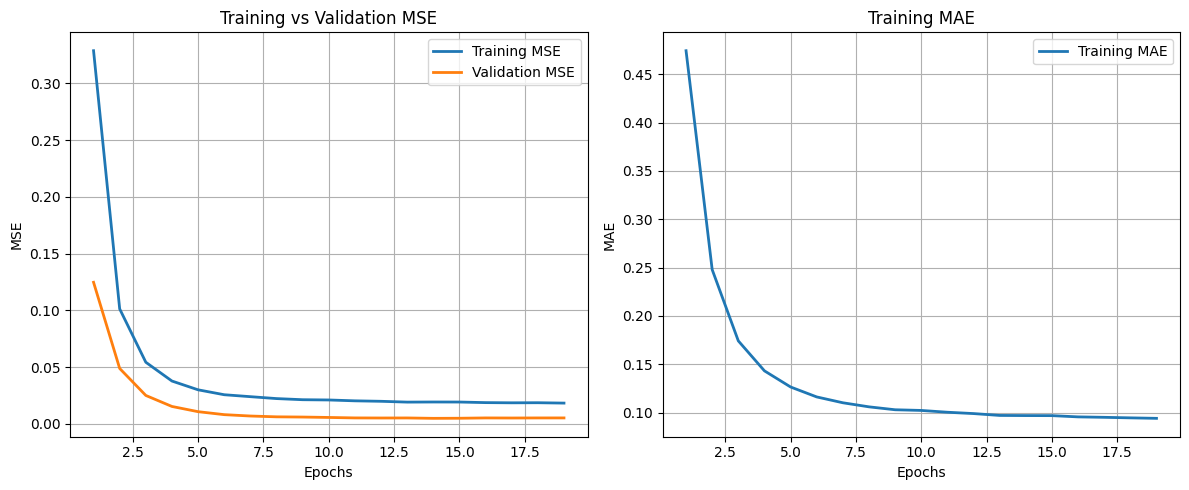

Saved training curves to adv_training_curves.png


In [9]:
import matplotlib.pyplot as plt

# Number of epochs actually completed
epochs_ran = len(train_mse_history)

plt.figure(figsize=(12, 5))

# ---------------- MSE Plot ----------------
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs_ran + 1), train_mse_history, label='Training MSE', linewidth=2)
plt.plot(range(1, epochs_ran + 1), val_mse_history, label='Validation MSE', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.title("Training vs Validation MSE")
plt.legend()
plt.grid(True)

# ---------------- MAE Plot ----------------
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs_ran + 1), train_mae_history, label='Training MAE', linewidth=2)
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("Training MAE")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("adv_training_curves.png", dpi=300)
plt.show()

print("Saved training curves to adv_training_curves.png")


In [10]:
# -------------------------
# 0. ONE-HOT encode temp & charge-rate
# -------------------------
df_one_hot = pd.get_dummies(df, columns=['temp','charge_rate'])

# -------------------------
# 1. Drop unused columns
# -------------------------
df_dropped = df_one_hot.drop(columns=['filename', 'cell_id', 'discharge_rate'])

# -------------------------
# 2. Identify columns
# -------------------------
ic_cols = [col for col in df_dropped.columns if 'IC' in col]      # 20 IC bins
cycle_col = 'cycle'
one_hot_cols = [col for col in df_dropped.columns
                if 'temp_' in col or 'charge_rate_' in col]

# Convert to arrays
X_ic_all = df_dropped[ic_cols].values               # (N,20)
X_cycle_all = df_dropped[[cycle_col]].values        # (N,1)
X_onehot_all = df_dropped[one_hot_cols].values      # (N,6)
Y = df_dropped['SOH'].values                        # (N,)

# ---------------------------------------------------
# 3. Remove NaN / INF first
# ---------------------------------------------------
mask_clean = (
    ~np.isnan(X_ic_all).any(axis=1) &
    ~np.isnan(X_cycle_all).any(axis=1) &
    ~np.isnan(X_onehot_all).any(axis=1) &
    ~np.isnan(Y) &
    ~np.isinf(X_ic_all).any(axis=1) &
    ~np.isinf(X_cycle_all).any(axis=1) &
    ~np.isinf(X_onehot_all).any(axis=1) &
    ~np.isinf(Y)
)

print("Rows removed due to NaN/Inf:", np.sum(~mask_clean))

X_ic_all     = X_ic_all[mask_clean]
X_cycle_all  = X_cycle_all[mask_clean]
X_onehot_all = X_onehot_all[mask_clean]
Y            = Y[mask_clean]


# ---------------------------------------------------
# 4. REMOVE IC OUTLIERS (YOUR RULE: IC < 0 OR IC > 20)
# ---------------------------------------------------
LOW_LIMIT  = 0
HIGH_LIMIT = 20

mask_outlier = np.all(
    (X_ic_all >= LOW_LIMIT) & (X_ic_all <= HIGH_LIMIT),
    axis=1
)

print("Rows removed due to IC outliers:", np.sum(~mask_outlier))

# Apply mask everywhere
X_ic_all     = X_ic_all[mask_outlier]
X_cycle_all  = X_cycle_all[mask_outlier]
X_onehot_all = X_onehot_all[mask_outlier]
Y            = Y[mask_outlier]


# -------------------------
# 5. Train-test split
# -------------------------
X_ic_train, X_ic_test, \
X_cycle_train, X_cycle_test, \
X_onehot_train, X_onehot_test, \
y_train, y_test = train_test_split(
    X_ic_all, X_cycle_all, X_onehot_all, Y,
    train_size=0.8, random_state=42
)

# -------------------------
# 6. Standardize IC bins
# -------------------------
ic_scaler = StandardScaler()
X_ic_train = ic_scaler.fit_transform(X_ic_train)
X_ic_test = ic_scaler.transform(X_ic_test)

# -------------------------
# 7. Standardize cycle number
# -------------------------
cycle_scaler = StandardScaler()
X_cycle_train = cycle_scaler.fit_transform(X_cycle_train)
X_cycle_test = cycle_scaler.transform(X_cycle_test)

# -------------------------
# 8. Build context vector = cycle + one-hot
# -------------------------
X_context_train = np.concatenate([X_cycle_train, X_onehot_train], axis=1)
X_context_test = np.concatenate([X_cycle_test, X_onehot_test], axis=1)

# -------------------------
# 9. Normalize SOH target
# -------------------------
y_mean = y_train.mean()
y_std = y_train.std()

y_train = (y_train - y_mean) / y_std
y_test  = (y_test - y_mean) / y_std

# -------------------------
# 10. Expand dims for CNN/LSTM input
# -------------------------
X_ic_train = np.expand_dims(X_ic_train, axis=2)
X_ic_test  = np.expand_dims(X_ic_test, axis=2)

# -------------------------
# 11. Print final shapes & ranges
# -------------------------
print("Final IC range:", X_ic_test.min(), X_ic_test.max())
print("IC:", X_ic_train.shape)
print("Context:", X_context_train.shape)
print("Y:", y_train.shape)


Rows removed due to NaN/Inf: 3
Rows removed due to IC outliers: 4
Final IC range: -8.413057359147434 11.611967272321516
IC: (18109, 20, 1)
Context: (18109, 7)
Y: (18109,)


In [11]:
adv_cw_gru = keras.models.load_model(r"/content/c&w_trained_cnn_gru.keras")

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


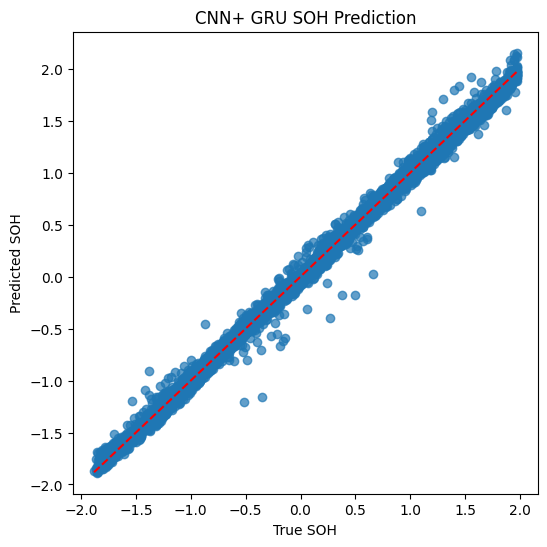

In [13]:
import matplotlib.pyplot as plt

y_pred = adv_cw_gru.predict([X_ic_test, X_context_test]).flatten()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True SOH")
plt.ylabel("Predicted SOH")
plt.title("CNN+ GRU SOH Prediction")
plt.show()

In [14]:
def candw_attack(model, X_ic_test, X_context_test, y_test, attack_weight = 1.0 , lr = 0.01, steps = 100, clip_min = -3.0, clip_max = 3.0):
    X_ic_test = tf.convert_to_tensor(X_ic_test, dtype= tf.float32)
    X_context_test = tf.convert_to_tensor(X_context_test, dtype= tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype= tf.float32)
    y_test = tf.expand_dims(y_test, axis = -1)

    delta = tf.Variable(tf.zeros_like(X_ic_test), trainable=True)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

    for _ in range(steps):
        with tf.GradientTape() as Tape:
            X_ic_adv = X_ic_test + delta
            X_ic_adv = tf.clip_by_value(X_ic_adv, clip_min, clip_max)

            y_pred = model([X_ic_adv, X_context_test], training=False)

            mse = tf.reduce_mean(tf.keras.losses.MSE(y_test, y_pred))

            l2 = tf.reduce_mean(tf.reduce_sum(tf.square(delta), axis =[1,2]))

            loss = l2 - attack_weight * mse

        gradient = Tape.gradient(loss, delta)
        optimizer.apply_gradients([(gradient,delta)])

    X_ic_adv = tf.clip_by_value(X_ic_adv + delta, clip_min, clip_max)

    return X_ic_adv.numpy()


In [19]:
from sklearn.metrics import mean_absolute_percentage_error

def attack_eval(model, X_ic_test, X_context_test, y_test, attack_weight = 1.0 , lr = 0.01, steps = 100, clip_min = -3.0, clip_max = 3.0, model_name=""):
    # Ensure numpy arrays with correct dtype and 1D targets
    X_ic_test = np.array(X_ic_test, dtype=np.float32)
    X_context_test = np.array(X_context_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32).ravel()

    # Generate adversarial IC inputs (returns numpy or tensor-like)
    X_ic_test_adv = candw_attack(model, X_ic_test, X_context_test, y_test, attack_weight, lr, steps, clip_min, clip_max)

    # Get predictions and ensure they are 1D numpy arrays
    y_pred = np.array(model.predict([X_ic_test, X_context_test])).ravel()
    y_pred_adv = np.array(model.predict([X_ic_test_adv, X_context_test])).ravel()

    # Compute metrics on flattened arrays
    print("-----------------")
    print("Normal Condition")
    print("-----------------")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MAE:", mean_absolute_error(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred))

    print("-------------")
    print("Attacked Data")
    print("-------------")
    print("R2 Score:", r2_score(y_test, y_pred_adv))
    print("MAE:", mean_absolute_error(y_test, y_pred_adv))
    print("MSE:", mean_squared_error(y_test, y_pred_adv))
    print("MAPE:", mean_absolute_percentage_error(y_test, y_pred_adv))

    print("-----")
    print("Plots")
    print("-----")

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.scatter(y_test, y_pred, alpha = 0.5)
    plt.title(model_name+" Clean Data Predictions")
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()

    plt.subplot(1,2,2)
    plt.scatter(y_test, y_pred_adv, alpha=0.5, color="orange")
    plt.title(model_name+" Attacked Data Predicitions")
    plt.plot([min_val,max_val],[min_val,max_val], "r--")
    plt.xlabel("True SOH")
    plt.ylabel("Predicted SOH")
    plt.grid()
    plt.show()


142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
-----------------
Normal Condition
-----------------
R2 Score: 0.9952489137649536
MAE: 0.04821532592177391
MSE: 0.00476412009447813
MAPE: 0.8280290961265564
-------------
Attacked Data
-------------
R2 Score: 0.9856991171836853
MAE: 0.07874833047389984
MSE: 0.01434013806283474
MAPE: 1.5521478652954102
-----
Plots
-----


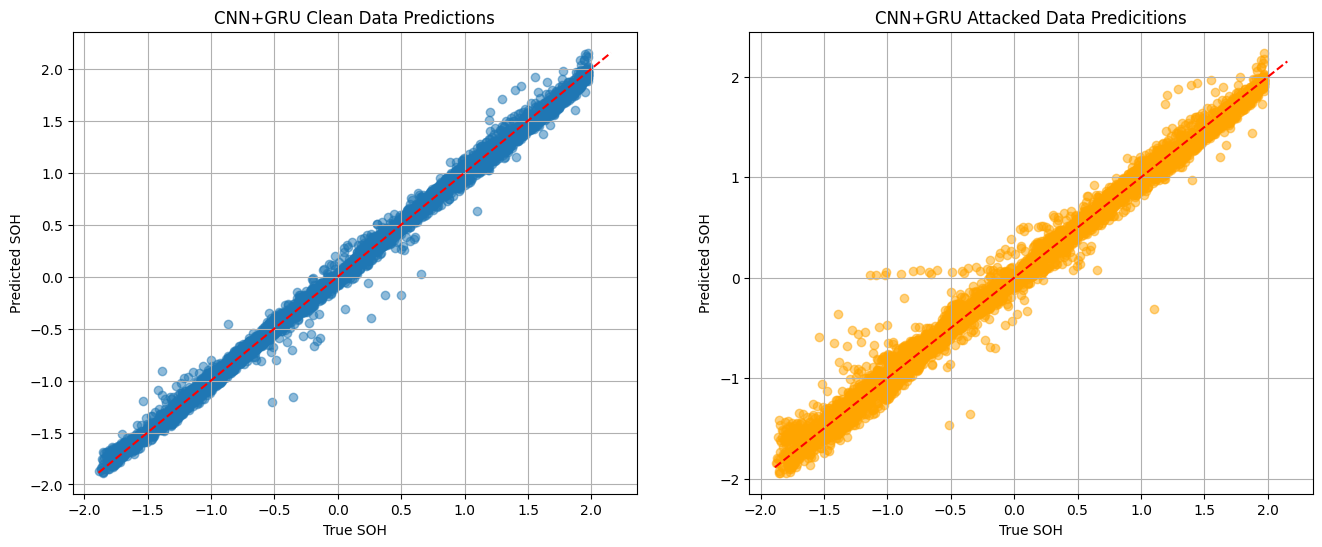

In [20]:
attack_eval(adv_cw_gru, X_ic_test, X_context_test, y_test, attack_weight=1.0 , lr = 0.01, steps = 100, clip_min = -3.0, clip_max = 3.0, model_name="CNN+GRU")